In [1]:
import copy
import os.path as osp
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.insert(0, "../src/")

In [2]:
# Plot params
mpl.style.use("seaborn-dark")
mpl.rcParams["axes.grid"] = True
mpl.rcParams["legend.frameon"] = True
mpl.rcParams["figure.dpi"] = 85
mpl.rcParams["axes.labelsize"] = "large"
mpl.rcParams["lines.linestyle"] = '-.'
mpl.rcParams["lines.marker"] = '*'


# This is the largest possible value of the logloss
logloss_inf_limit = -np.log(np.finfo("float").eps)

In [3]:
res_path = osp.join(
    "..", "output", "real_data_20200906_140935", "results.csv"
)  # only 3
res_path = osp.join(
    "..", "output", "real_data_20200906_120919", "results.csv"
)  # all from aws cpu
res_path = osp.join("..", "output", "uci_experiment_20200910_120958", "results.csv")

# local
res_paths = [
    osp.join("..", "output", "uci_experiment_20200912_170902", "results.csv"),
    osp.join("..", "output", "uci_experiment_20200912_170932", "results.csv"),
    osp.join("..", "output", "uci_experiment_20200912_170941", "results.csv"),
    osp.join("..", "output", "uci_experiment_20200912_170956", "results.csv"),
    osp.join("..", "output", "uci_experiment_20200912_180914", "results.csv"),
    osp.join("..", "output", "uci_experiment_20200912_180945", "results.csv"),
]

# aws
res_paths = [
    osp.join("..", "output", "uci_experiment_20200912_170912", "results.csv"),
    osp.join("..", "output", "uci_experiment_20200912_170919", "results.csv"),
    osp.join("..", "output", "uci_experiment_20200912_170924", "results.csv"),
    osp.join("..", "output", "uci_experiment_20200912_170951", "results.csv"),
    osp.join("..", "output", "uci_experiment_20200912_190900", "results.csv"),
    osp.join("..", "output", "uci_experiment_20200912_200934", "results.csv"),
]


# aws
res_paths = [
    osp.join("..", "output", "uci_experiment_20200915_150927", "results.csv"),
    osp.join("..", "output", "uci_experiment_20200915_160953", "results.csv"),
    osp.join("..", "output", "uci_experiment_20200915_170950", "results.csv"),
    osp.join("..", "output", "uci_experiment_20200915_190931", "results.csv"),
    osp.join("..", "output", "uci_experiment_20200916_030943", "results.csv"),
]
res_dfs = [pd.read_csv(res_path) for res_path in res_paths]

In [4]:
# Take the mean over experimetns
res_list = []
for res_df in res_dfs:
    dataset_name = res_df.dataset_name.unique()
    assert len(dataset_name) == 1
    dataset_name = dataset_name[0]

    # Filter samples that the pNML was not converged there from empirical reasons
    res_df = res_df[res_df["empirical_pnml_success"] == True]
    res_df = res_df[res_df.trainset_size>3]

    print(f"{dataset_name}. \t num_featues={res_df.num_features.mean()}. trainset sizes={res_df.trainset_size.unique()}")
    res_mean_df = res_df.groupby("trainset_size").mean().reset_index()
    res_std_df = res_df.groupby("trainset_size").agg(np.std, ddof=0).reset_index()
    res_count_df= res_df.groupby("trainset_size").agg("count")

    res_list.append(
        {
            "dataset_name": dataset_name,
            "mean_df": res_mean_df,
            "std_df": res_std_df,
            "count_df": res_count_df,
        }
    )

bostonHousing. 	 num_featues=14.0. trainset sizes=[  4   5   6   7   8   9  10  11  12  13  14  15  21  31  45  65  94 135
 196 283 409]
concrete. 	 num_featues=9.0. trainset sizes=[  4   5   6   7   8   9  10  16  26  43  71 116 190 312 510 834]
kin8nm. 	 num_featues=9.0. trainset sizes=[   4    5    6    7    8    9   10   20   42   87  179  369  760 1565
 3223 6634]
naval-propulsion-plant. 	 num_featues=17.0. trainset sizes=[   4    5    6    7    8    9   10   11   12   13   14   15   16   17
   36   72  146  294  591 1189 2391 4807 9665]
wine-quality-red. 	 num_featues=12.0. trainset sizes=[   4    5    6    7    8    9   10   11   12   21   36   60  100  167
  279  465  776 1295]


In [5]:
def plot_confidence_interval(ax, mean, std, count, color: str):
    mean, std, count = np.array(mean), np.array(std), np.array(count)
    lower = mean - 1.960 * std / np.sqrt(count)
    upper = mean + 1.960 * std / np.sqrt(count)
    ax.fill_between(trainset_size, upper, lower, color=color, alpha=0.1)  # std curves

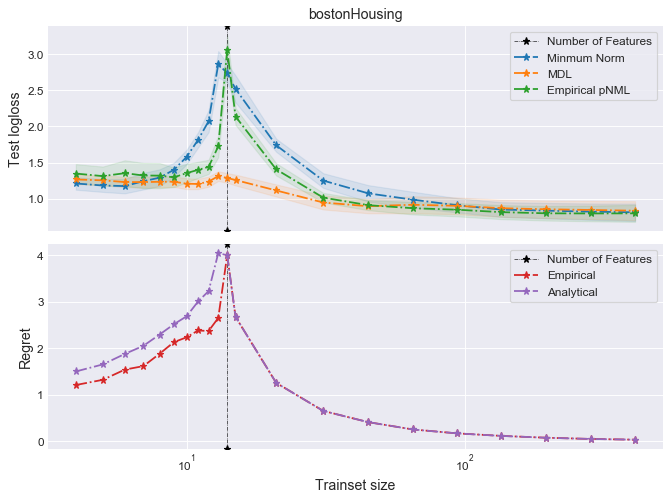

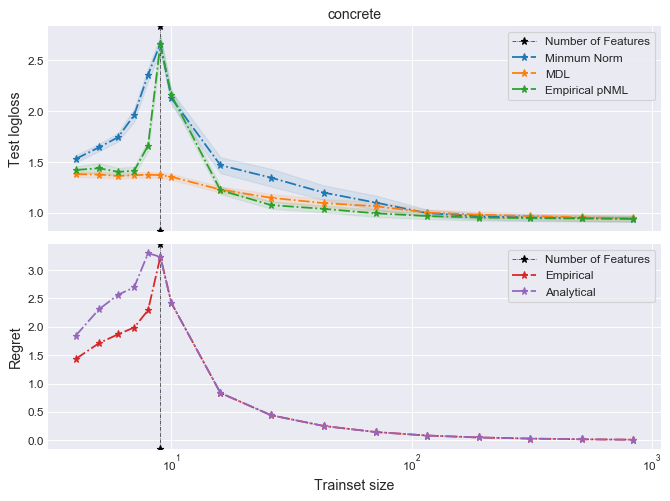

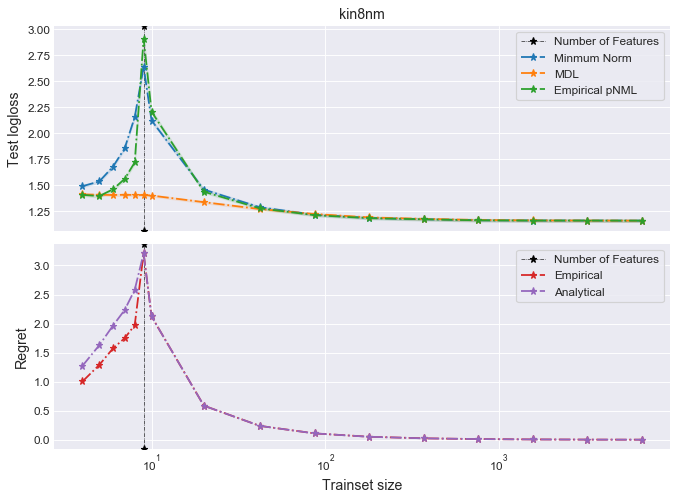

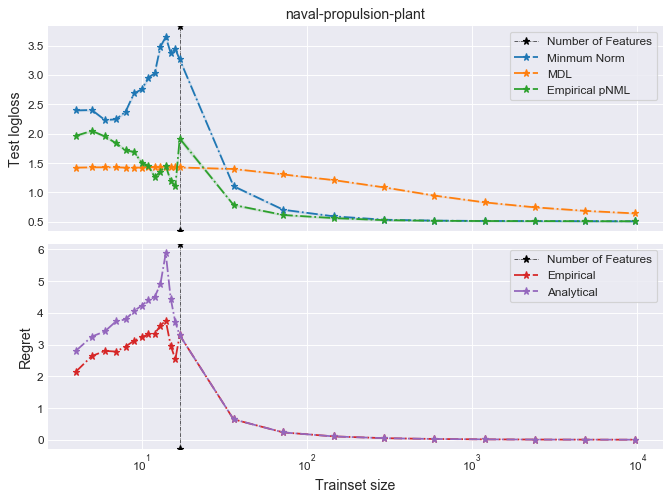

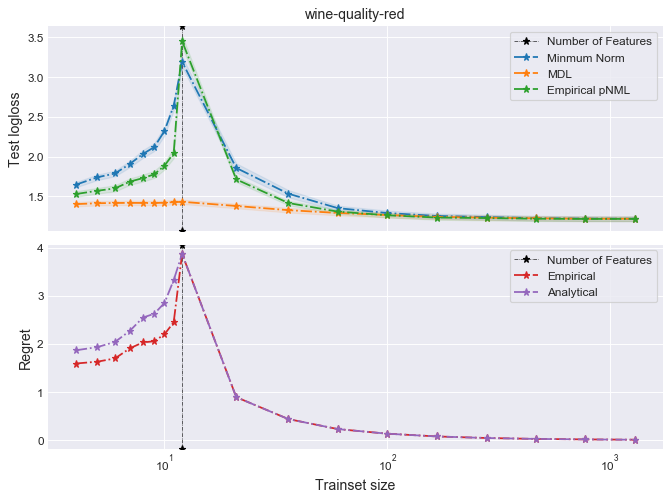

In [6]:
# Plot performence
for res_dict in res_list:
    dataset_name = res_dict["dataset_name"]
    res_mean_df = res_dict["mean_df"]
    res_std_df = res_dict["std_df"]
    res_count_df = res_dict["count_df"]

    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

    [
        ax.axvline(
            res_mean_df["num_features"].mean(),
            color="black",
            linewidth=0.5,
            label="Number of Features",
        )
        for ax in axs
    ]

    ax = axs[0]
    trainset_size = res_mean_df["trainset_size"]
    ax.plot(trainset_size, res_mean_df["mn_test_logloss"], label="Minmum Norm")
    ax.plot(trainset_size, res_mean_df["mdl_test_logloss"], label="MDL")
    ax.plot(
        trainset_size,
        res_mean_df["empirical_pnml_test_logloss"],
        label="Empirical pNML",
    )

    key = "mn_test_logloss"
    plot_confidence_interval(
        ax, res_mean_df[key], res_std_df[key], res_count_df[key], "C0"
    )
    key = "mdl_test_logloss"
    plot_confidence_interval(
        ax, res_mean_df[key], res_std_df[key], res_count_df[key], "C1"
    )
    key = "empirical_pnml_test_logloss"
    plot_confidence_interval(
        ax, res_mean_df[key], res_std_df[key], res_count_df[key], "C2"
    )

    ax.legend(loc=1)
    ax.set_ylabel("Test logloss")

    ax = axs[1]
    ax.plot(
        trainset_size,
        res_mean_df["empirical_pnml_regret"],
        label="Empirical",
        color="C3",
    )
    ax.plot(
        trainset_size,
        res_mean_df["analytical_pnml_regret"],
        label="Analytical",
        color="C4",
    )
    ax.legend(loc=1)
    ax.set_ylabel("Regret")
    ax.set_xlabel("Trainset size")

    axs[0].set_title(dataset_name)
    plt.xscale("symlog")
    # plt.yscale('symlog')
    plt.tight_layout()
    plt.show()